In [44]:
import numpy as np 
import math
import os 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy
import seaborn as sns 
import pickle
import pandas as pd
import time
import datetime
# sns.set()
# sns.set_style("ticks")
# sns.set_style("darkgrid")
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,  RANSACRegressor, TheilSenRegressor, Ridge 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

import torch
from torch import nn, optim
import torch.nn.functional as F

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing

In [2]:
    Dataset = r'15minute_data_newyork\15minute_data_newyork.csv'
    fulldata = pd.read_csv(Dataset) 

    # savedata = r'SaveData\\'
    # Answers = r'Hw_Results\\'

In [3]:
data=fulldata[['dataid','local_15min','grid']]

In [4]:
data['dataid'].value_counts().count()

25

In [5]:
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])

In [6]:
ids=sorteddata['dataid'].unique().tolist()

In [7]:
housing_data = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for regession 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)



In [8]:
# foo = foo[:-3]

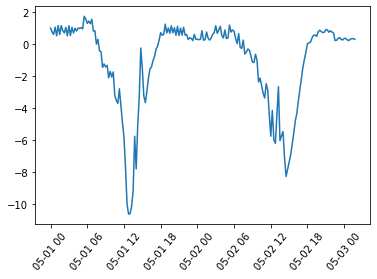

In [9]:
# housing_data[0].head(200).plot.scatter(x='local_15min', y='grid')

df = housing_data[0].head(200)
plt.xticks(rotation=50)
plt.plot(df['local_15min'], df['grid'])


In [10]:
housing_data[0]['local_15min']

0       2019-05-01 00:00:00
1       2019-05-01 00:15:00
2       2019-05-01 00:30:00
3       2019-05-01 00:45:00
4       2019-05-01 01:00:00
                ...        
17658   2019-10-31 22:45:00
17659   2019-10-31 23:00:00
17660   2019-10-31 23:15:00
17661   2019-10-31 23:30:00
17662   2019-10-31 23:45:00
Name: local_15min, Length: 17663, dtype: datetime64[ns]

In [11]:
housing_data[0]['15min_ints']

0        737180.000000
1        737180.010417
2        737180.020833
3        737180.031250
4        737180.041667
             ...      
17658    737363.947917
17659    737363.958333
17660    737363.968750
17661    737363.979167
17662    737363.989583
Name: 15min_ints, Length: 17663, dtype: float64

# LSTM

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

In [12]:
dates = housing_data[0]['15min_ints'].to_numpy()
grid_data = housing_data[0]['grid'].to_numpy()

dates = np.reshape(dates, (len(dates), 1))
grid_data = np.reshape(grid_data, (len(grid_data), 1))
last_idx = 200

In [13]:
# regress = SVR(kernel= 'rbf', C= 1, gamma= 'auto')
# regress = SVR(kernel='rbf', C=1e4, gamma=0.1)

# regress = SVR(kernel='linear')
# regress = SVR(kernel='linear', gamma='auto')
# regress = SVR(kernel='rbf', C=1e3, gamma=100)
# regress = SVR(kernel='linear', C=1e3)
# regress = SVR(kernel='rbf', C=1e3, gamma=.1)
# regress = SVR(kernel='rbf', gamma=0.2, C=100)
# regress = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# regress =  Ridge (alpha = .5)
# regress = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
# regress = SVR(kernel='poly', C=2, degree=3, epsilon=0.0009923) #doesn't work for some reason?
regress = MultiOutputRegressor(SVR(kernel='rbf', C=1e6),n_jobs=-1)
#
#
#
#C:\Users\natha\Google Drive\Grad\Spring2021\ECE696\Project\HousingData.ipynb
#
#
#
#
#
#

#.........
# regress = tree.DecisionTreeRegressor(criterion='friedman_mse', max_depth=10)

# regress = SVR(kernel='poly', C=1000, gamma='auto', degree=3, epsilon=.1, coef0=1)

# polynomial_features  = PolynomialFeatures(degree=50,include_bias=False)
# # Regressor = RANSACRegressor(random_state=42)
# # Regressor = TheilSenRegressor(random_state=42)
# # Regressor = LinearRegression()
# regress = Pipeline([("polynomial_features", polynomial_features), ("regression", Regressor)])

last_idx = 10000
regress.fit(dates[:last_idx], grid_data[:last_idx])

# model = HWES(grid_data[:last_idx], seasonal_periods=12, trend='add', seasonal='mul')
# fitted = model.fit(optimized=True, use_brute=True)
# print(fitted.summary())
# forecast = fitted.forecast(steps=12)
# regress.fit(dates, grid_data)

score = cross_val_score(regress, dates[:last_idx], grid_data[:last_idx],scoring="neg_mean_squared_error", cv=10)

# score = cross_val_score(regress, dates[:last_idx], grid_data[:last_idx],scoring="neg_mean_squared_error", cv=10)
print(score.mean())
if abs(score.mean()) < 1: print('Good fit')

-6246.632077059282


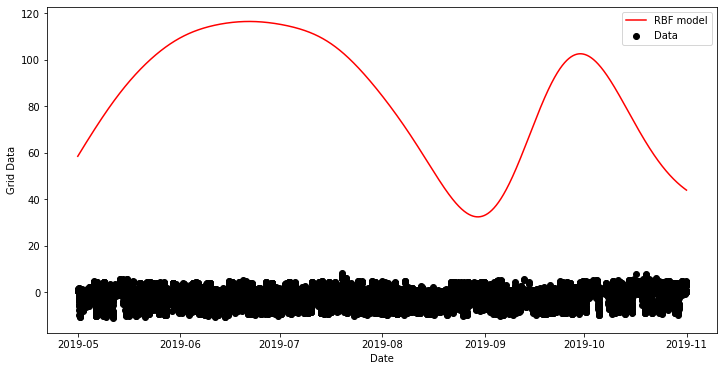

In [14]:
last_idx = -1
plt.figure(figsize = (12,6))
plt.scatter(dates[:last_idx], grid_data[:last_idx], color= 'black', label= 'Data')
plt.plot(housing_data[0]['local_15min'][:last_idx], regress.predict(dates)[:last_idx], color= 'red', label= 'RBF model') 
# plt.plot(housing_data[0]['local_15min'][:last_idx], forecast, color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Grid Data')
plt.legend()
plt.show()

In [22]:
train_size = math.floor(len(grid_data) * 4/5)
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)})

svr.fit(dates[:train_size], grid_data[:train_size])
kr.fit(dates[:train_size], grid_data[:train_size])

GridSearchCV(estimator=KernelRidge(gamma=0.1, kernel='rbf'),
             param_grid={'alpha': [1.0, 0.1, 0.01, 0.001],
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

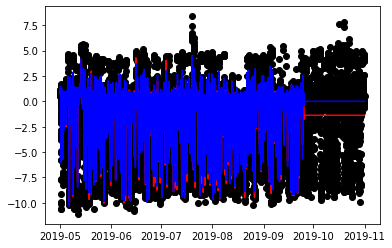

In [23]:
last_idx = -1
plt.scatter(dates[:last_idx], grid_data[:last_idx], color= 'black', label= 'Data')
plt.plot(housing_data[0]['local_15min'][:last_idx], svr.predict(dates)[:last_idx], color= 'red', label= 'svr model') 
plt.plot(housing_data[0]['local_15min'][:last_idx], kr.predict(dates)[:last_idx], color= 'blue', label= 'kr model') 


In [25]:
grid_data.shape

(17663, 1)

In [26]:
dates.shape

(17663, 1)

In [27]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [30]:
data=housing_data[0][['15min_ints','grid']]

In [31]:
data

,15min_ints,grid
0,737180.000000,0.997
1,737180.010417,0.750
2,737180.020833,0.608
3,737180.031250,1.057
4,737180.041667,0.518
...,...,...
17658,737363.947917,3.971
17659,737363.958333,4.301
17660,737363.968750,2.591
17661,737363.979167,0.548


In [34]:
train_df, val_df = train_test_split(
  data,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [35]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)

In [36]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [37]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [38]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [41]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [42]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [51]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=300
)

s 573882.616584507
Epoch 4: train loss 572453.8494388197 val loss 571024.1532042254
Epoch 5: train loss 569595.3955113902 val loss 568165.7157042254
Epoch 6: train loss 566736.9419419836 val loss 565307.241584507
Epoch 7: train loss 563878.4887222741 val loss 562448.8148239437
Epoch 8: train loss 561020.035111237 val loss 559590.3407042254
Epoch 9: train loss 558161.581795777 val loss 556731.9032042254
Epoch 10: train loss 555303.1287301006 val loss 553873.4657042254
Epoch 11: train loss 552444.6754521081 val loss 551014.991584507
Epoch 12: train loss 549586.222049224 val loss 548156.5648239437
Epoch 13: train loss 546727.7686380137 val loss 545298.0907042254
Epoch 14: train loss 543869.3149062479 val loss 542439.5907042254
Epoch 15: train loss 541010.8616407447 val loss 539581.1532042254
Epoch 16: train loss 538152.406501865 val loss 536722.7157042254
Epoch 17: train loss 535293.9497227403 val loss 533864.2782042254
Epoch 18: train loss 532435.4964031173 val loss 531005.8148239437
Epo

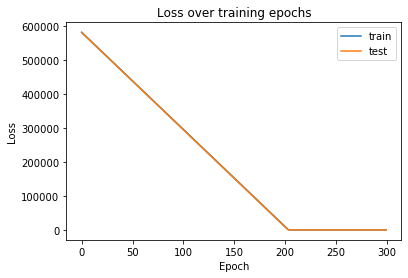

In [52]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [53]:
MODEL_PATH = '0house_model.pth'

torch.save(model, MODEL_PATH)

In [54]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

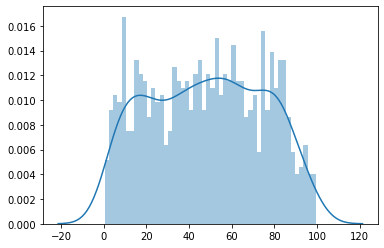

In [55]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [57]:
THRESHOLD = 26
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 229/875


In [58]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

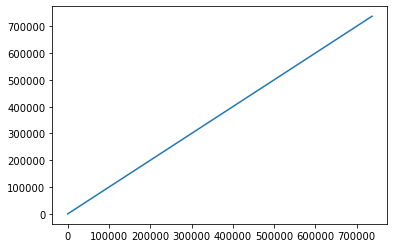

In [64]:
plt.plot(predictions[0],predictions[1])

In [ ]:
last_idx = -1
plt.figure(figsize = (12,6))
plt.scatter(dates[:last_idx], grid_data[:last_idx], color= 'black', label= 'Data')
plt.plot(housing_data[0]['local_15min'][:last_idx], regress.predict(dates)[:last_idx], color= 'red', label= 'RBF model') 
# plt.plot(housing_data[0]['local_15min'][:last_idx], forecast, color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Grid Data')
plt.legend()
plt.show()

In [67]:
predictions[2]

array([7.3726650e+05, 2.5777882e-01], dtype=float32)

In [81]:
model.eval()
test_idx = 400
test_set = np.asarray([dates[0], grid_data[0]])
result = model(test_set)

TypeError: 'int' object is not callable